<a href="https://colab.research.google.com/github/Maya7991/gsc_classification/blob/main/mfcc_mel_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install snnTorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.5 MB/s eta 0:00:00


In [3]:
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

import snntorch as snn
from snntorch import spikegen

In [4]:
torch.manual_seed(0)

# Load dataset
dataset = torchaudio.datasets.SPEECHCOMMANDS("./", download=True, subset="training")

# Pick one or more samples
waveform, sample_rate, label, *_ = dataset[0]
print(f"Label: {label}, Sample Rate: {sample_rate}, Shape: {waveform.shape}")
target_length = sample_rate

100%|██████████| 2.26G/2.26G [00:24<00:00, 97.6MB/s]


Label: backward, Sample Rate: 16000, Shape: torch.Size([1, 16000])


waveform truncated


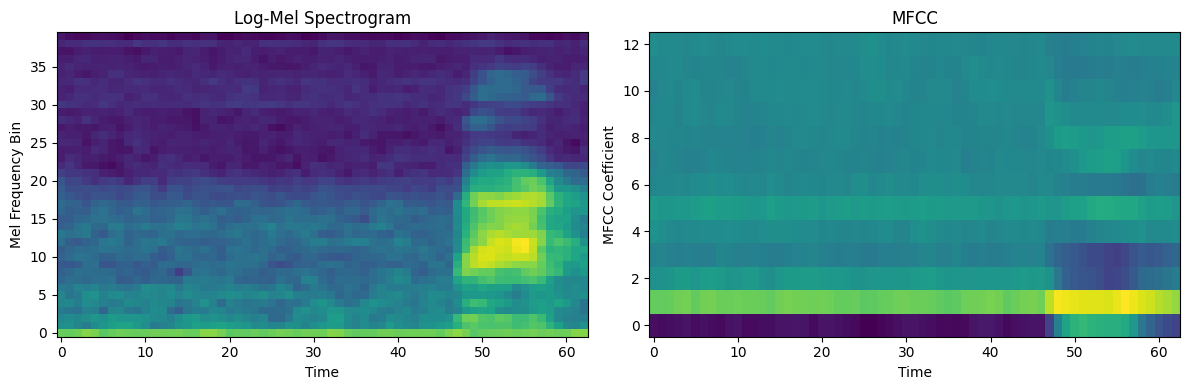

In [27]:
# Pad or truncate waveform
if waveform.size(1) < target_length:
    pad_size = target_length - waveform.size(1)
    waveform = F.pad(waveform, (0, pad_size))
    print("waveform padded")
else:
    waveform = waveform[:, :target_length]
    print("waveform truncated")

# Define transforms
mel_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=256,
    n_mels=40
)

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=13,
    melkwargs={
        'n_fft': 1024,
        'hop_length': 256,
        'n_mels': 40
    }
)

# Apply transforms
mel_spec = mel_transform(waveform).squeeze(0)
mfcc_spec = mfcc_transform(waveform).squeeze(0)

# Convert Mel to log scale for better visualization
log_mel_spec = torch.log(mel_spec + 1e-9)
# log_mel_spec = mel_spec

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(log_mel_spec.numpy(), origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title('Log-Mel Spectrogram')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mel Frequency Bin')

axs[1].imshow(mfcc_spec.numpy(), origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title('MFCC')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('MFCC Coefficient')

plt.tight_layout()
plt.show()


In [29]:
# Normalizations
def min_max_norm(x):
    return (x - x.min()) / (x.max() + 1e-6)

def z_score_norm(x):
    return (x - x.mean()) / (x.std() + 1e-5)

mel_type = 'raw' # 'log' or 'raw'
if mel_type == 'log':
    mel_spec = torch.log(mel_spec + 1e-9)
else:
    mel_spec = mel_spec

mel_ttfs = min_max_norm(mel_spec)
mel_rate = z_score_norm(mel_spec)

mfcc_ttfs = min_max_norm(mfcc_spec)
mfcc_rate = z_score_norm(mfcc_spec)

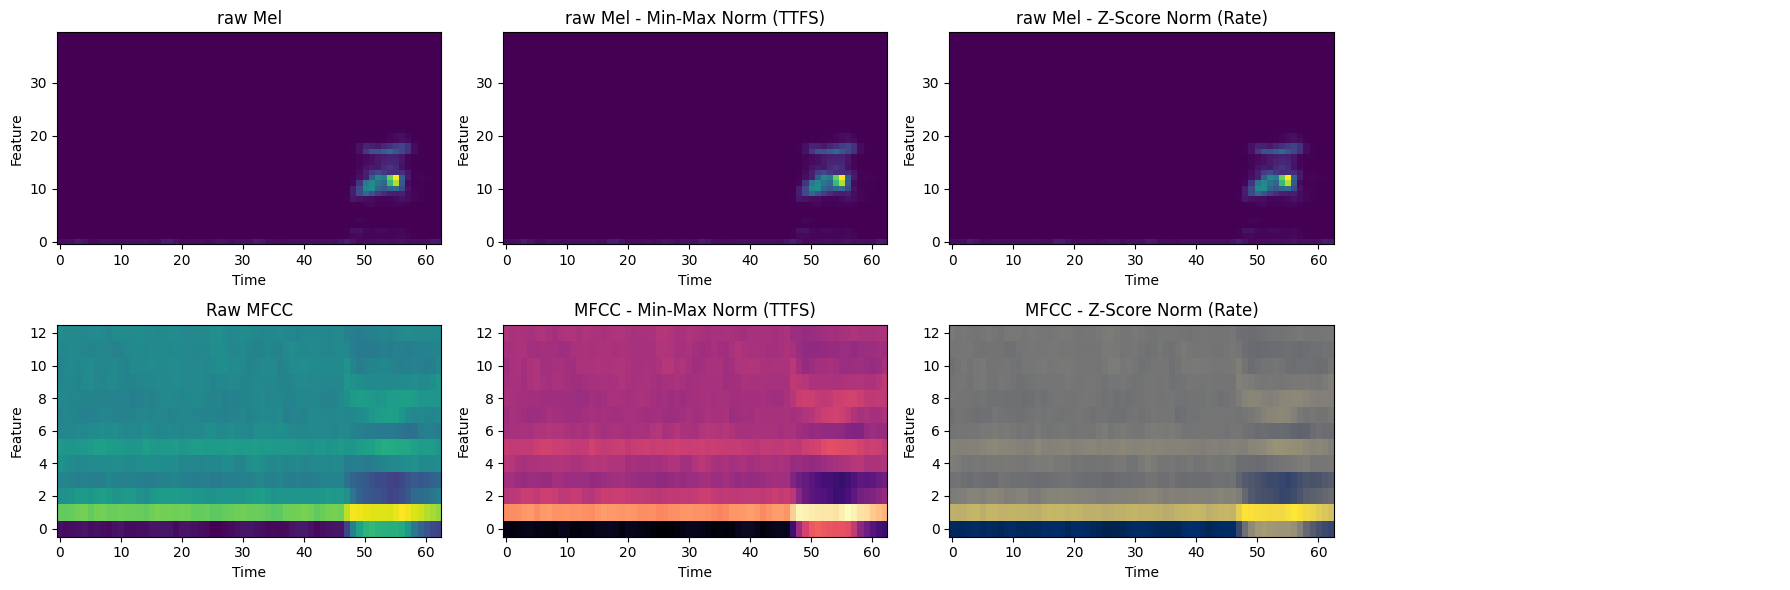

In [30]:
# Plot Mel and MFCC with both normalizations
fig, axs = plt.subplots(2, 4, figsize=(18, 6))

# Mel Spectrograms
axs[0, 0].imshow(mel_spec.numpy(), origin='lower', aspect='auto', cmap='viridis')
axs[0, 0].set_title(f'{mel_type} Mel')

axs[0, 1].imshow(mel_ttfs.numpy(), origin='lower', aspect='auto', cmap='viridis') # magma
axs[0, 1].set_title(f'{mel_type} Mel - Min-Max Norm (TTFS)')

axs[0, 2].imshow(mel_rate.numpy(), origin='lower', aspect='auto', cmap='viridis') # cividis
axs[0, 2].set_title(f'{mel_type} Mel - Z-Score Norm (Rate)')

axs[0, 3].axis('off')  # Leave a blank slot or you can duplicate log-mel

# MFCCs
axs[1, 0].imshow(mfcc_spec.numpy(), origin='lower', aspect='auto', cmap='viridis')
axs[1, 0].set_title('Raw MFCC')

axs[1, 1].imshow(mfcc_ttfs.numpy(), origin='lower', aspect='auto', cmap='magma')
axs[1, 1].set_title('MFCC - Min-Max Norm (TTFS)')

axs[1, 2].imshow(mfcc_rate.numpy(), origin='lower', aspect='auto', cmap='cividis')
axs[1, 2].set_title('MFCC - Z-Score Norm (Rate)')

axs[1, 3].axis('off')  # Blank slot for symmetry

# Common formatting
for ax_row in axs:
    for ax in ax_row:
        ax.set_xlabel("Time")
        ax.set_ylabel("Feature")
plt.tight_layout()
plt.show()